# 🧩 Data Curation & Preprocessing
- Tasks:
    - Load and filter dataset, then prepare each datapoint
    - Explore, visualize, balance price distribution
    - Export .pkl, upload to HF Hub
- 🧑‍💻 Skill Level: Advanced
- ⚙️ Hardware: ✅ CPU is sufficient — no GPU required
- 🛠️ Requirements: 
    - 🔑 Hugging Face token must be defined in `.env`
    - run `uv sync --group notebook` , then select the `.venv` kernel

---
📝 **Note:** This notebook is part of a series. Check out the full set [here](https://github.com/lisekarimi/lexo).

In [ ]:
# Magic commands first
%matplotlib inline

# imports
import importlib
import os
import random
import sys
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset, DatasetDict
from dotenv import load_dotenv
from huggingface_hub import login

In [ ]:
# environment

load_dotenv(override=True)
hf_token = os.getenv("HF_TOKEN")
if not hf_token:
    print("❌ HF_TOKEN is missing")
login(hf_token, add_to_git_credential=True)

## ⚙️ Data Loading & Curation (Simultaneously)
We load and curate the data at the same time using loaders.py and items.py.
- Datasets come from [Hugging Face](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories)
- `loaders.py` handles parallel loading and filtering of products
- `items.py` defines the Item class to clean, validate, and prepare each datapoint (title, description, price...) for modeling.

⚠️ Loading 2.8M+ items can take 40+ mins on a regular laptop.

⚠️ Set WORKER wisely in `loaders.py` to match your system capacity. Too many may crash your machine.

In [ ]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [ ]:
sys.path.append("./helpers")
import helpers.items
import helpers.loaders

importlib.reload(helpers.items)
importlib.reload(helpers.loaders)

from helpers.items import Item
from helpers.loaders import ItemLoader

items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

# Now, time for a tea break 🍵 !!
# By the way, the larger datasets first... it speeds up the process.

## 🔍 Inspecting a Sample Datapoint

In [ ]:
print(f"A grand total of {len(items):,} items")

In [ ]:
# Investigate the first item from the list

datapoint = items[0]

# Access various attributes
title = datapoint.title
details = datapoint.details
price = datapoint.price
category = datapoint.category

print(f"Datapoint: {datapoint}")
print("*" * 40)
print(f"Title: {title}")
print("*" * 40)
print(f"Detail: {details}")
print("*" * 40)
print(f"Price: ${price}")
print("*" * 40)
print(f"Category: {category}")

In [ ]:
# The prompt that will be used during training
print(items[0].prompt)
print("*" * 40)
# The prompt that will be used during testing
print(items[0].test_prompt())

## 📊 Data Visualization

In [ ]:
plt.figure(figsize=(15, 6))

In [ ]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
avg_tokens = f"{sum(tokens) / len(tokens):,.1f}"
plt.title(f"Token counts: Avg {avg_tokens} and highest {max(tokens):,}\n")
plt.xlabel("Length (tokens)")
plt.ylabel("Count")
plt.hist(tokens, rwidth=0.7, color="blue", bins=range(0, 300, 10))
plt.show()

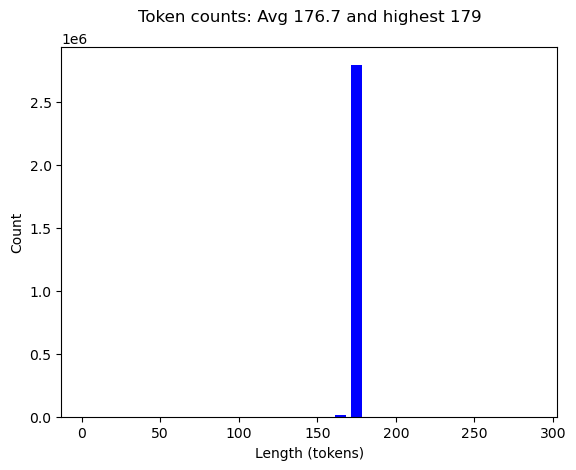

In [ ]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.title(f"Prices: Avg {sum(prices) / len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

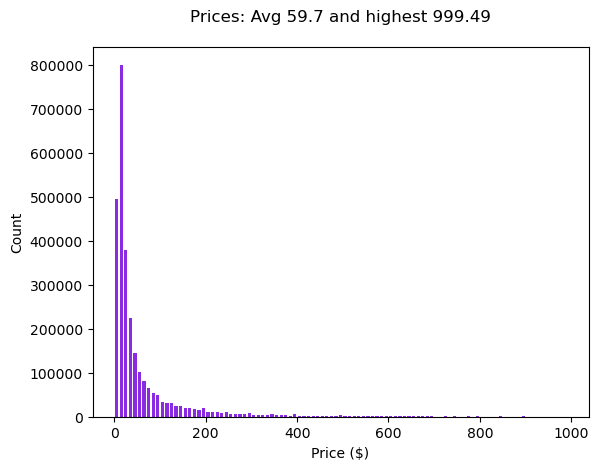

In [ ]:
# Plot the distribution of categories

category_counts = Counter()
for item in items:
    category_counts[item.category] += 1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.bar(categories, counts, color="goldenrod")
plt.title("How many items in each category")
plt.xlabel("Categories")
plt.ylabel("Count")

plt.xticks(rotation=30, ha="right")

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")

# Display the chart
plt.show()

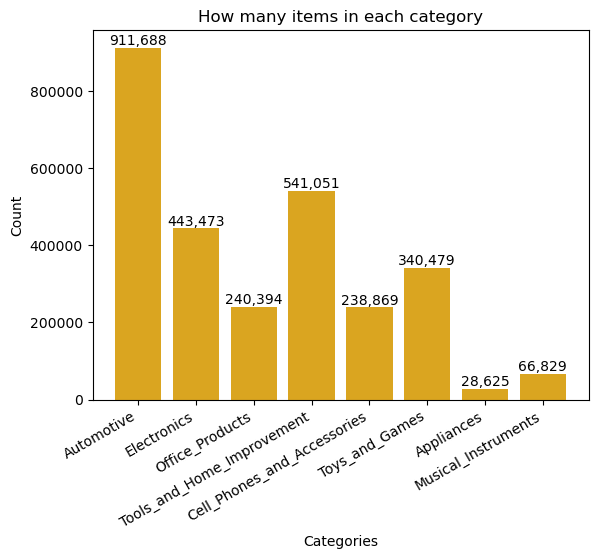

## 🎯 Data Sampling

We sample to keep the dataset balanced but rich:
- 🎯 Keep all items if price ≥ $240 or group size ≤ 1200
- 🎯 For large groups, randomly sample 1200 items, favoring rare categories

✅ This keeps valuable high-price items and avoids overrepresented classes

In [ ]:
HEAVY_DATASET = "Automative"

# Group items by rounded price
# Slots is a dictionary where the keys are rounded prices
# and the values are lists of items that have that rounded price
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

np.random.seed(42)  # Set random seed for reproducibility
sample = []  # Final collection of items after our sampling process completes

# Sampling loop
for price, items_at_price in slots.items():
    # Take all items if price ≥ 240 or small group
    if price >= 240 or len(items_at_price) <= 1200:
        sample.extend(items_at_price)

    # Otherwise sample 1200 items with weights
    else:
        # Weight: 1 for toys, 5 for others
        weights = [
            1 if item.category == HEAVY_DATASET else 5 for item in items_at_price
        ]
        weights = np.array(weights) / sum(weights)

        indices = np.random.choice(
            len(items_at_price),
            1200,
            replace=False,  # don't pick the same index twice
            p=weights,
        )
        sample.extend([items_at_price[i] for i in indices])

print(f"There are {len(sample):,} items in the sample")

In [ ]:
# Plot the distribution of prices in the sample

prices = [float(item.price) for item in sample]
plt.title(f"Avg {sum(prices) / len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

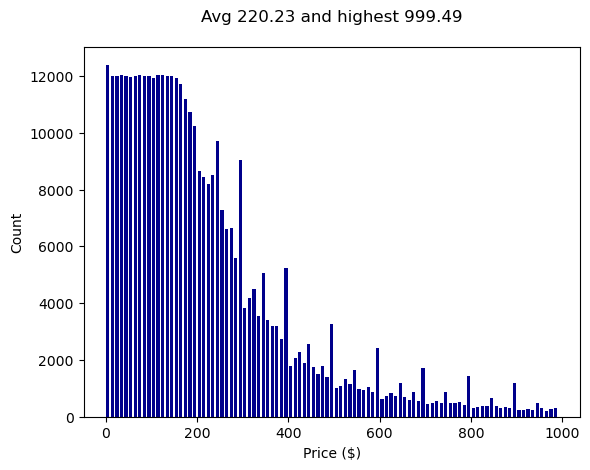

In [ ]:
# Plot the distribution of categories in the sample

category_counts = Counter()
for item in sample:
    category_counts[item.category] += 1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.bar(categories, counts, color="pink")

# Customize the chart
plt.title("How many in each category")
plt.xlabel("Categories")
plt.ylabel("Count")

plt.xticks(rotation=30, ha="right")

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha="center", va="bottom")

# Display the chart
plt.show()

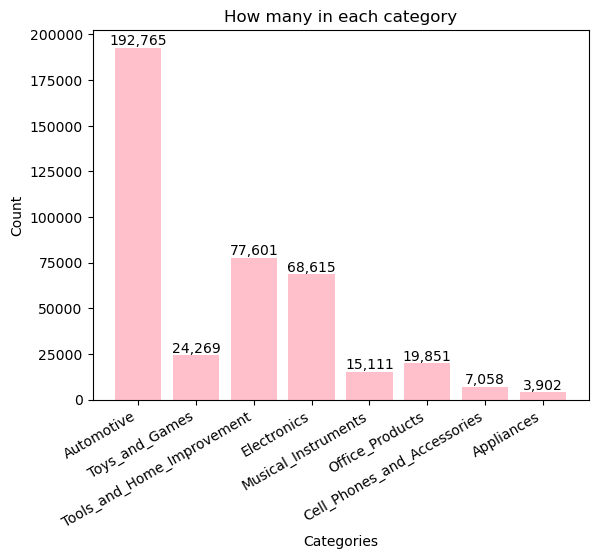

The HEAVY_DATASET still in the lead, but improved somewhat

In [ ]:
# Create pie chart

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    counts,
    # labels=categories,
    autopct="%1.0f%%",
    startangle=90,
    pctdistance=0.85,
    labeldistance=1.1,
)
ax.legend(
    wedges,
    categories,
    title="Categories",
    loc="lower center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
)

# Draw donut center
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)

# Add center label
ax.text(0, 0, "Categories", ha="center", va="center", fontsize=14, fontweight="bold")

# Equal aspect ratio
plt.axis("equal")
plt.title("Category Distribution")
plt.tight_layout()
plt.show()

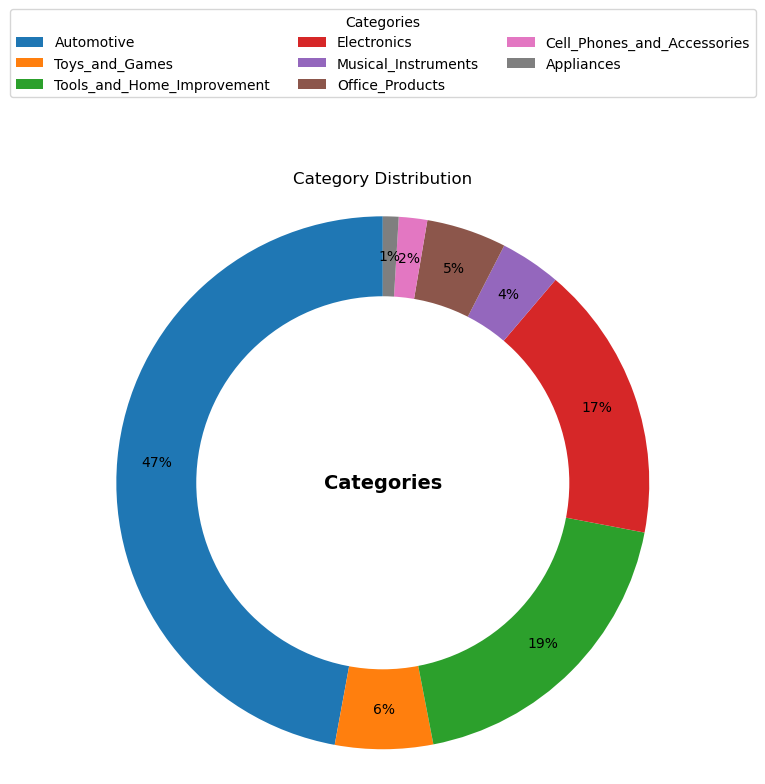

In [ ]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel("Size")
plt.ylabel("Price")
plt.title("Is there a simple correlation between prompt length and item price?")

# Display the plot
plt.show()

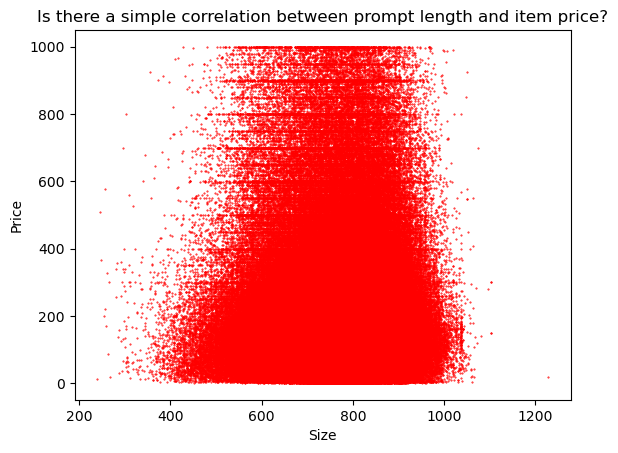

There is no strong or simple correlation between prompt length and item price.

In other words, longer prompts don’t clearly mean higher prices, and vice versa.

## ✅ Final Check Before Training

In [ ]:
# Ensure the price label is correctly placed by the end of the prompt


def report(item) -> None:
    """Print debugging information about an item's prompt and its tokenization."""
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-6:])
    print(Item.tokenizer.batch_decode(tokens[-6:]))


report(sample[50])

LLaMA and GPT-4o both tokenize numbers from 1 to 999 as a single token, while models like Qwen2, Gemma, and Phi-3 split them into multiple tokens. This helps keep prices compact in our prompts — useful for our project, though not strictly required.

## 📦 Creating Train/Test Datasets

In [ ]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(
    f"Divided into a training set of {len(train):,} items "
    f"and test set of {len(test):,} items"
)

In [ ]:
print(train[0].prompt)
print("*" * 40)
print(test[0].test_prompt())

In [ ]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices) / len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel("Price ($)")
plt.ylabel("Count")
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

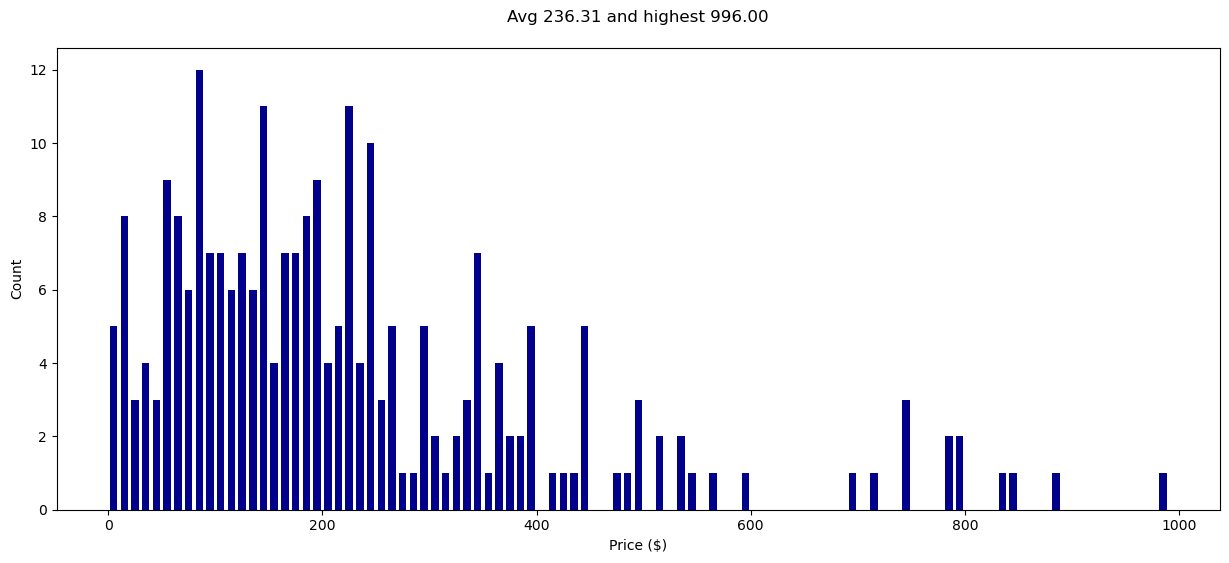

In [ ]:
#  Extract prompts and prices
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

# Create Hugging Face datasets
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

# Push to the Hugging Face Hub
USERNAME = "lisekarimi"  # 🔧 Replace with your Hugging Face username
DATASET_NAME = f"{USERNAME}/pricer-data"

dataset.push_to_hub(DATASET_NAME, private=True)

**Note:** 
- The dataset `pricer-data` on Hugging Face only contains `text` and `price`:

{
  "text": "How much does this cost...Price is $175.00",
  "price": 175.0
}


---

This is the final dataset for the full project.

It will be used to:
- [Generate embeddings and store them in ChromaDB](02_e5_xgboost.ipynb)
- [Train an XGBoost model for price prediction](02_e5_xgboost.ipynb)
- [Fine-tune a LLaMA model using QLoRA](03_ft_llama_qlora.ipynb)
- [Build a linear ensemble model that combines RAG, XGBoost, and the fine-tuned LLaMA](05_ensemble_model.ipynb)



